In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, find_center
from DRP_vel_map_plottingFunctions import plot_rot_curve

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

# Sample galaxy properties

In [3]:
gal_ID = '7443-12702'
#gal_ID = '8263-12702'
#gal_ID = '8486-12701'

manga_plate, manga_IFU = gal_ID.split('-')
gal_filename = VEL_MAP_FOLDER + manga_plate + '/' + manga_IFU + '/manga-' + gal_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz'

In [4]:
Ha_vel, Ha_vel_ivar, Ha_vel_mask, r_band, r_band_ivar = extract_data(gal_filename)

mr_band = ma.array(r_band, mask=Ha_vel_mask)
mHa_vel = ma.array(Ha_vel, mask=Ha_vel_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

In [5]:
oneD_fit_file = '../spirals/DRPall-master_file_30.txt'

oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [6]:
i_angle = np.arccos(gal_oneD_fit_parameters_row['ba'][0])
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)
v_sys = mHa_vel[center]
phi = gal_oneD_fit_parameters_row['phi'][0].value*np.pi/180
v_max = gal_oneD_fit_parameters_row['avg_v_max'][0].value
r_turn = gal_oneD_fit_parameters_row['avg_r_turn'][0].value
alpha = gal_oneD_fit_parameters_row['avg_alpha'][0]

# Find spaxel along semi-major axis
delta_x = int(center[1]*0.25)
delta_y = int(delta_x/np.tan(phi))
semi_major_axis_spaxel = tuple(np.subtract(center, (-delta_y, delta_x)))

# Check value along semi-major axis
if mHa_vel[semi_major_axis_spaxel] < 0:
    phi_guess = phi + np.pi
else:
    phi_guess = phi
    
params = [v_sys, i_angle, center[0], center[1], phi_guess, v_max, r_turn, alpha]
best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}

138.95299999999997
138.95299999999997


In [7]:
map_shape = mHa_vel.shape

In [8]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

### Initial guesses used in fit

# Test `model_vel_map`

In [9]:
model_map_BB = model_vel_map(params, 
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

model_map_tanh = model_vel_map(params[:-1], map_shape, pix_scale_factor, 'tanh')

[3.975092, 0.27776752482593803, 53, 36, 2.4251873555236805, 850.4977644301074, 2.7437310860925037, 3.977989682196256]
[3.975092, 0.27776752482593803, 53, 36, 2.4251873555236805, 850.4977644301074, 2.7437310860925037]


<IPython.core.display.Javascript object>


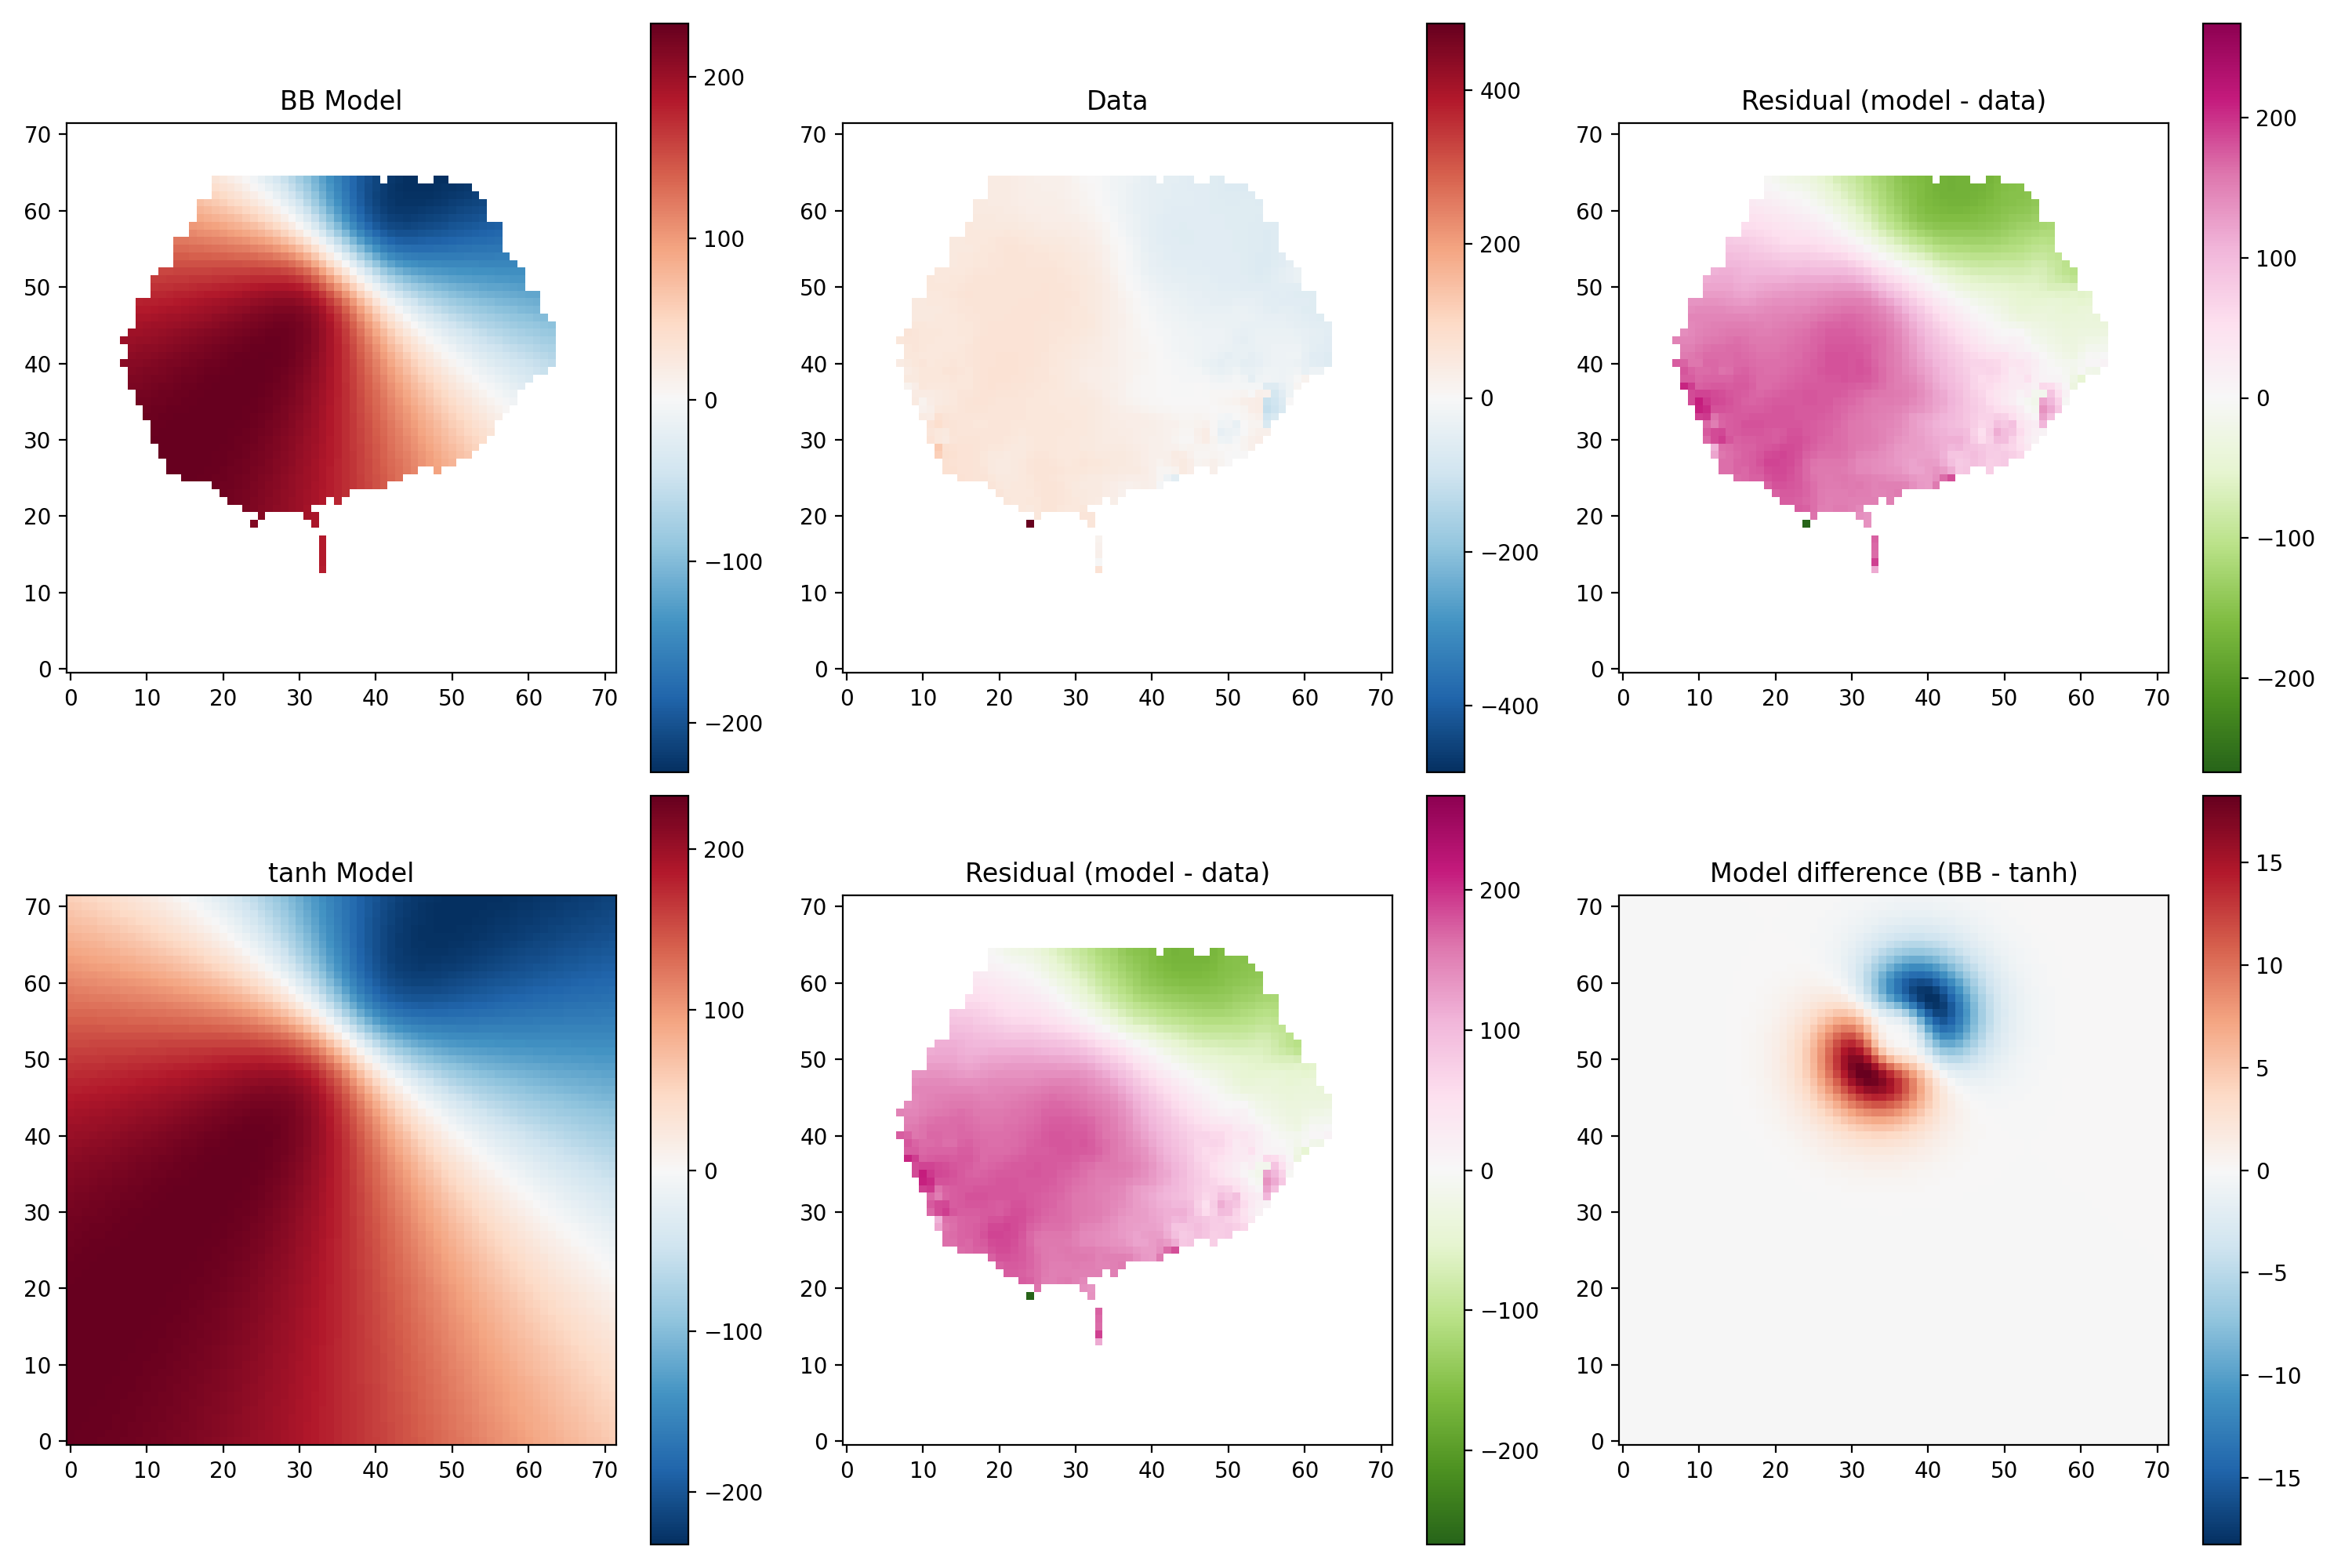

In [10]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
           origin='lower', 
           cmap='RdBu_r')
plt.colorbar()
plt.title('BB Model')

plt.subplot(232)
extreme2 = np.max(np.abs(mHa_vel))
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.colorbar()
plt.title('Data')

plt.subplot(233)
residual_BB = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_BB, vmax=residual_BB)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(234)
plt.imshow(model_map_tanh - v_sys, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('tanh Model')

plt.subplot(235)
residual_tanh = np.max(np.abs(model_map_tanh - mHa_vel))
plt.imshow(model_map_tanh - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_tanh, vmax=residual_tanh)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(236)
plt.imshow(model_map_BB - model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Model difference (BB - tanh)')

plt.tight_layout();

# Test `plot_rot_curve`

<IPython.core.display.Javascript object>


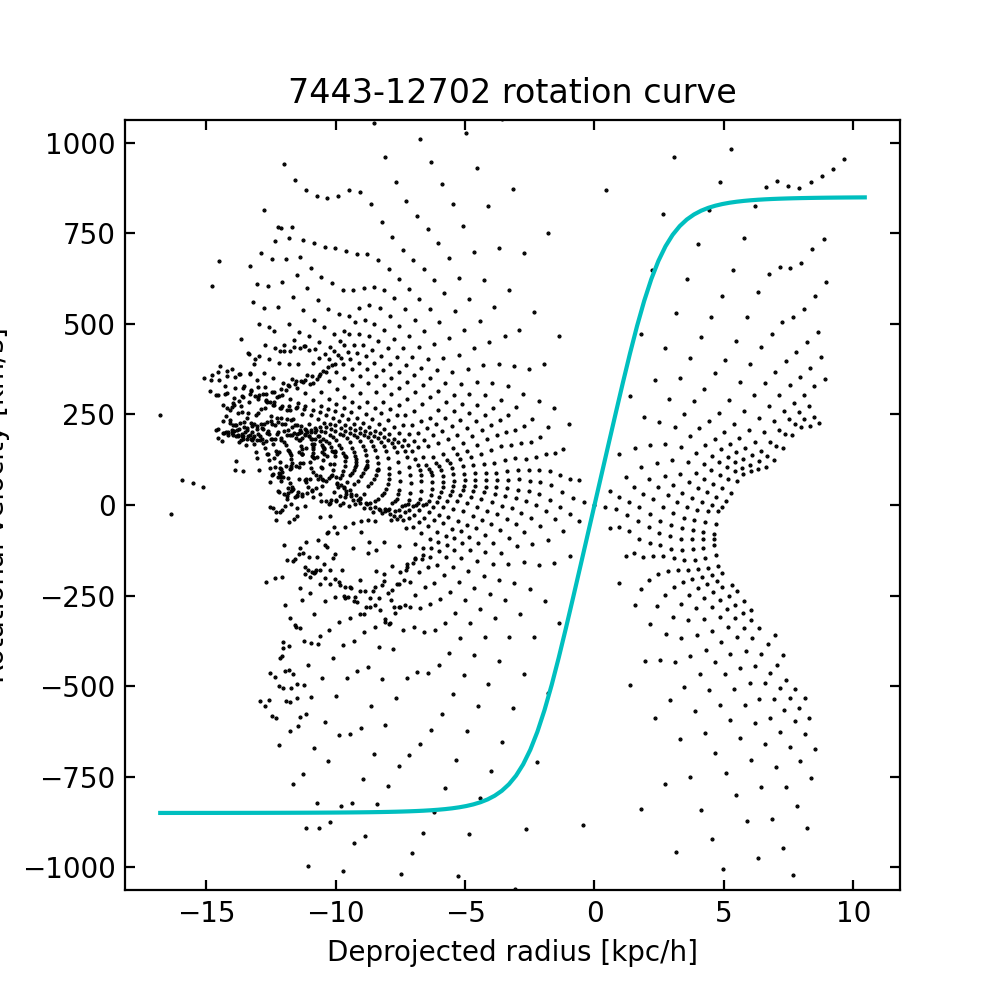

In [11]:
best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}

plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values, pix_scale_factor, gal_ID, 'BB');

In [12]:
plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values, pix_scale_factor, gal_ID, 'tanh')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


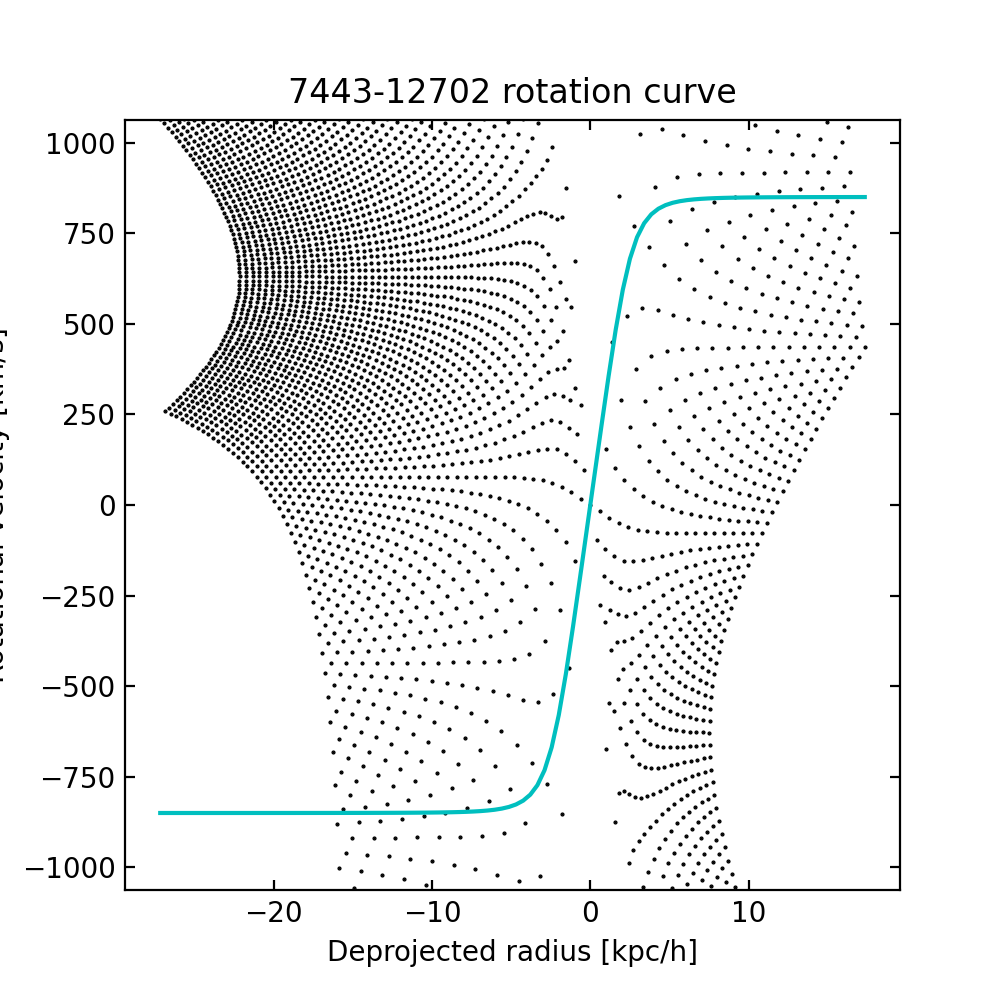

In [13]:
model_map_BB_masked = ma.array(model_map_BB, mask=np.zeros(map_shape))

plot_rot_curve(model_map_BB_masked, mHa_vel_ivar, best_fit_values, pix_scale_factor, gal_ID, 'BB');

# Test `find_center`

In [9]:
maybe_center = find_center(mHa_vel)

In [10]:
maybe_center

(43, 46)

<IPython.core.display.Javascript object>


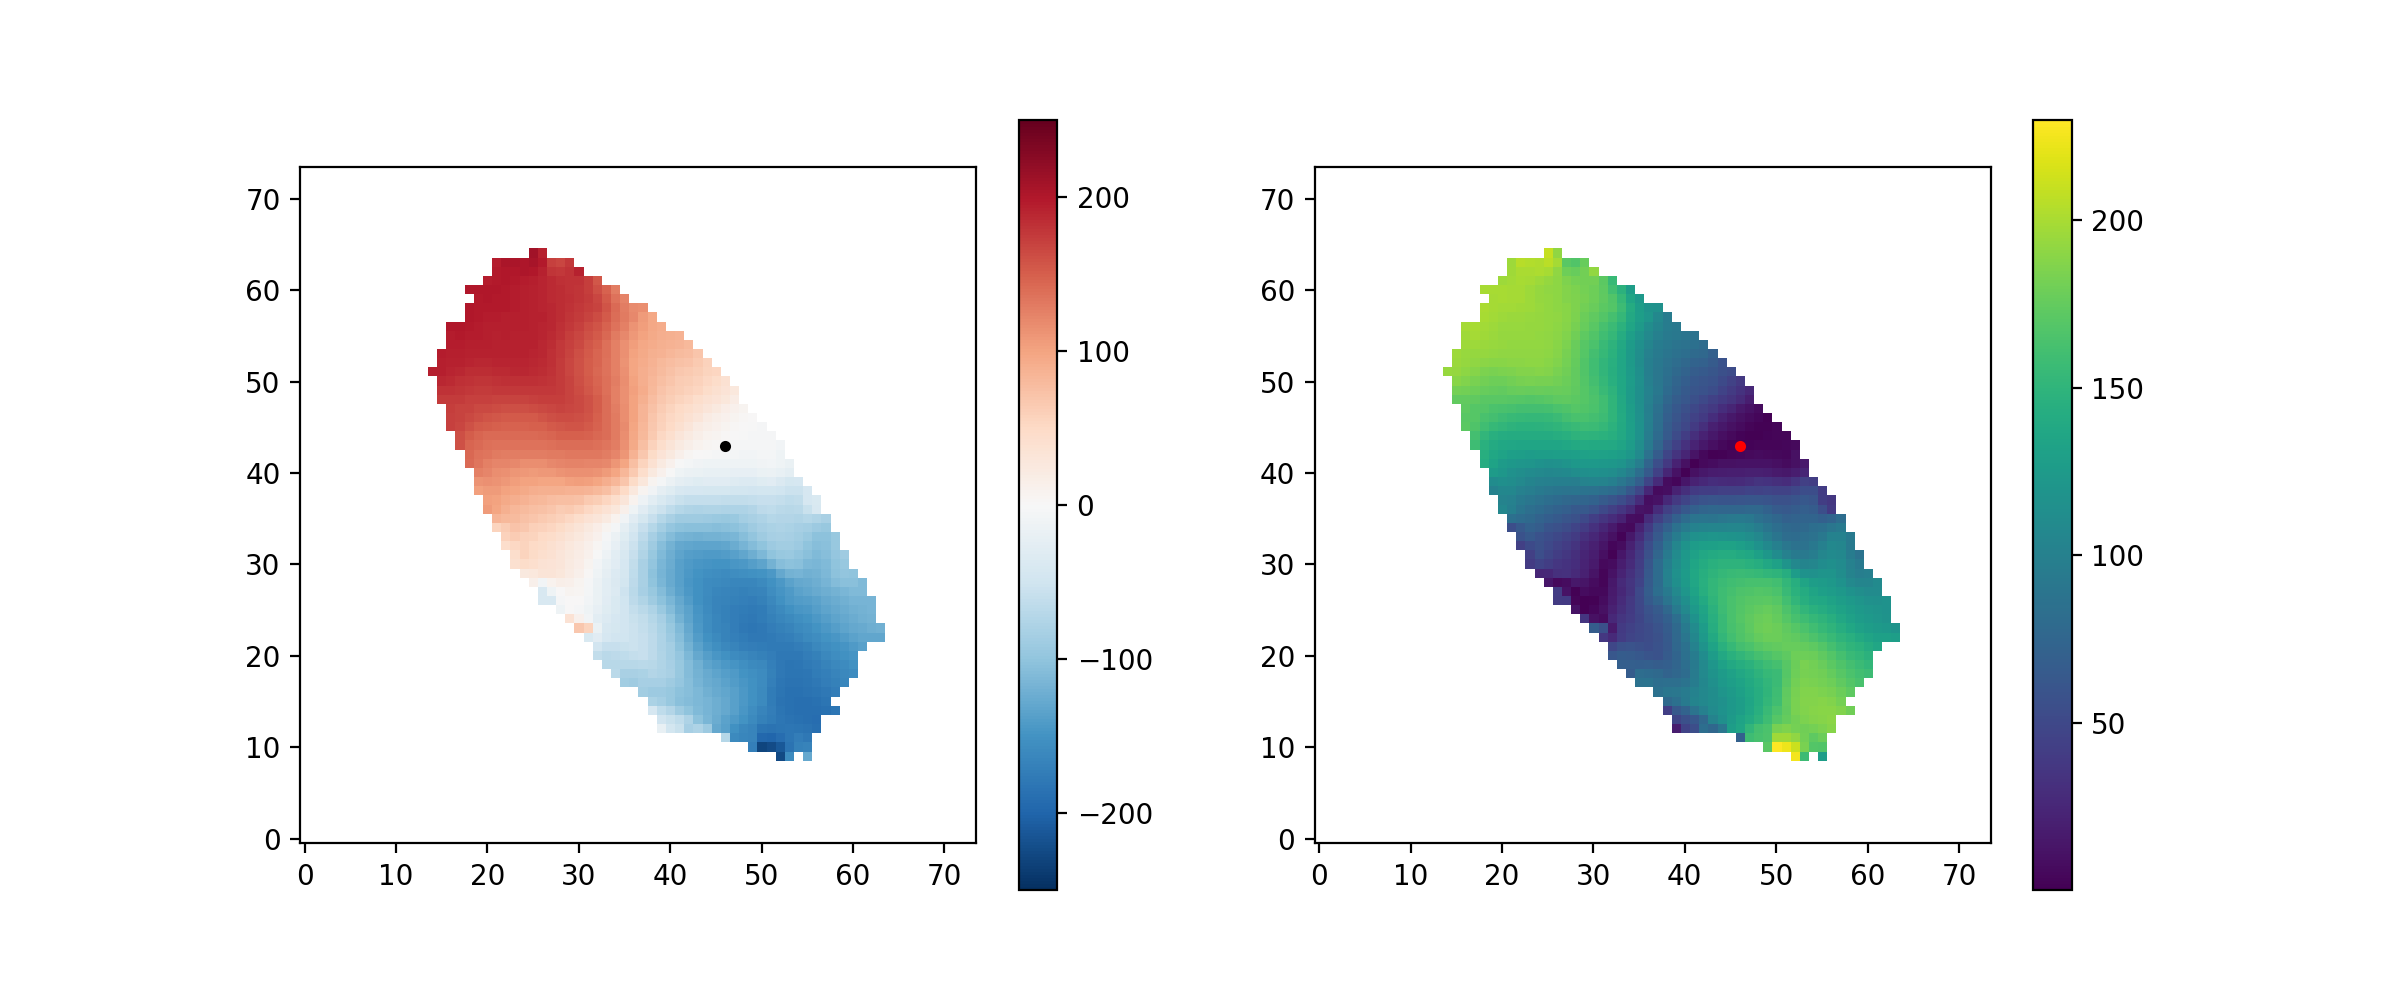

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

In [12]:
x = np.arange(map_shape[0])
X, Y = np.meshgrid(x,x)

<IPython.core.display.Javascript object>


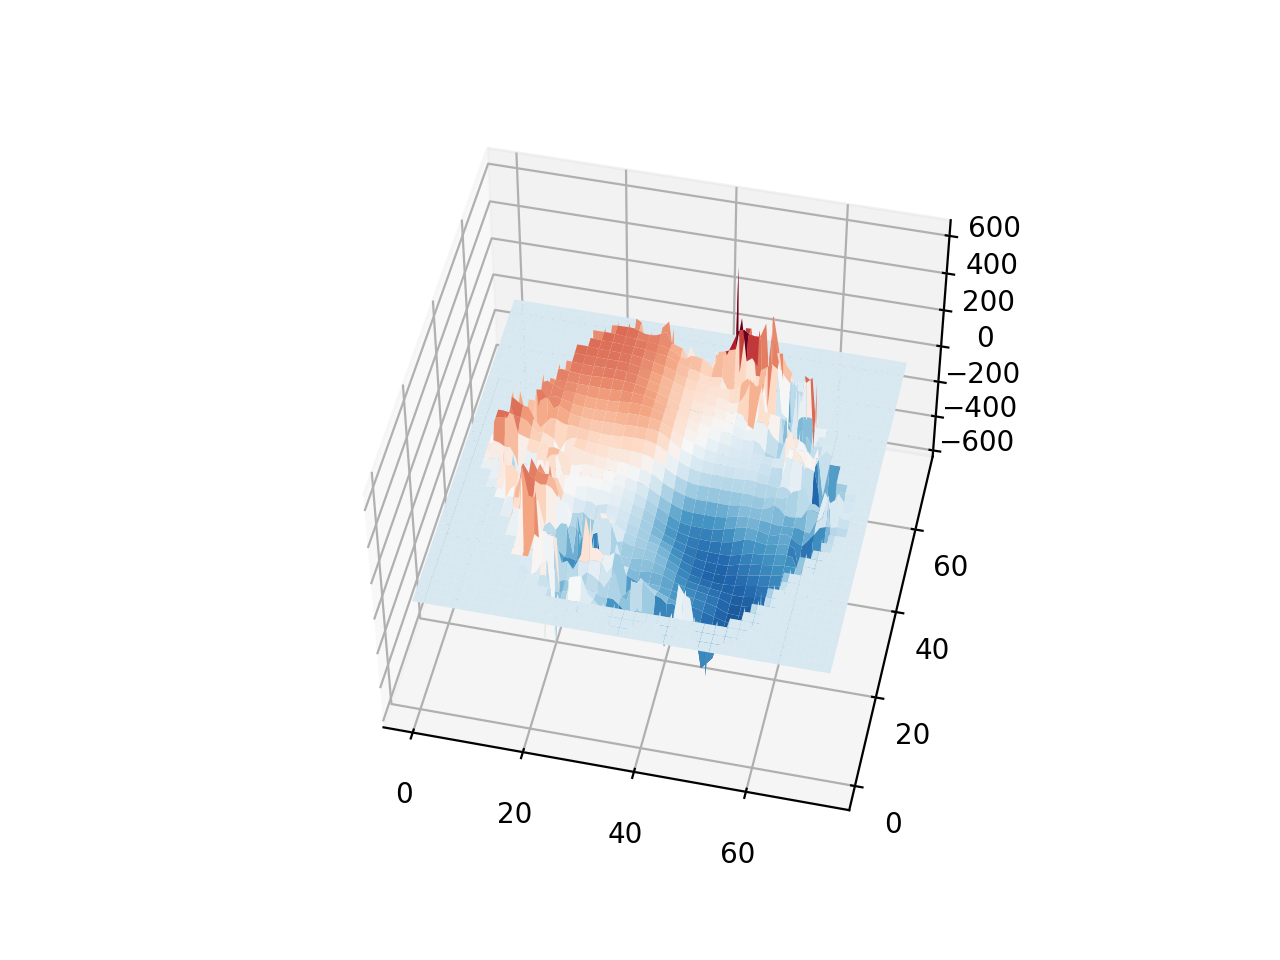

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, mHa_vel, cmap='RdBu_r');
#plt.colorbar();

In [28]:
i_angle

1.0683978716829448